The following example was taken and modified from [here](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/DocVQA/Quick_inference_with_DONUT_for_DocVQA.ipynb). Click [here](https://huggingface.co/docs/transformers/model_doc/donut) to learn more about DONUT.

In [1]:
from transformers import DonutProcessor, VisionEncoderDecoderModel
from pdf2image import convert_from_path
import re

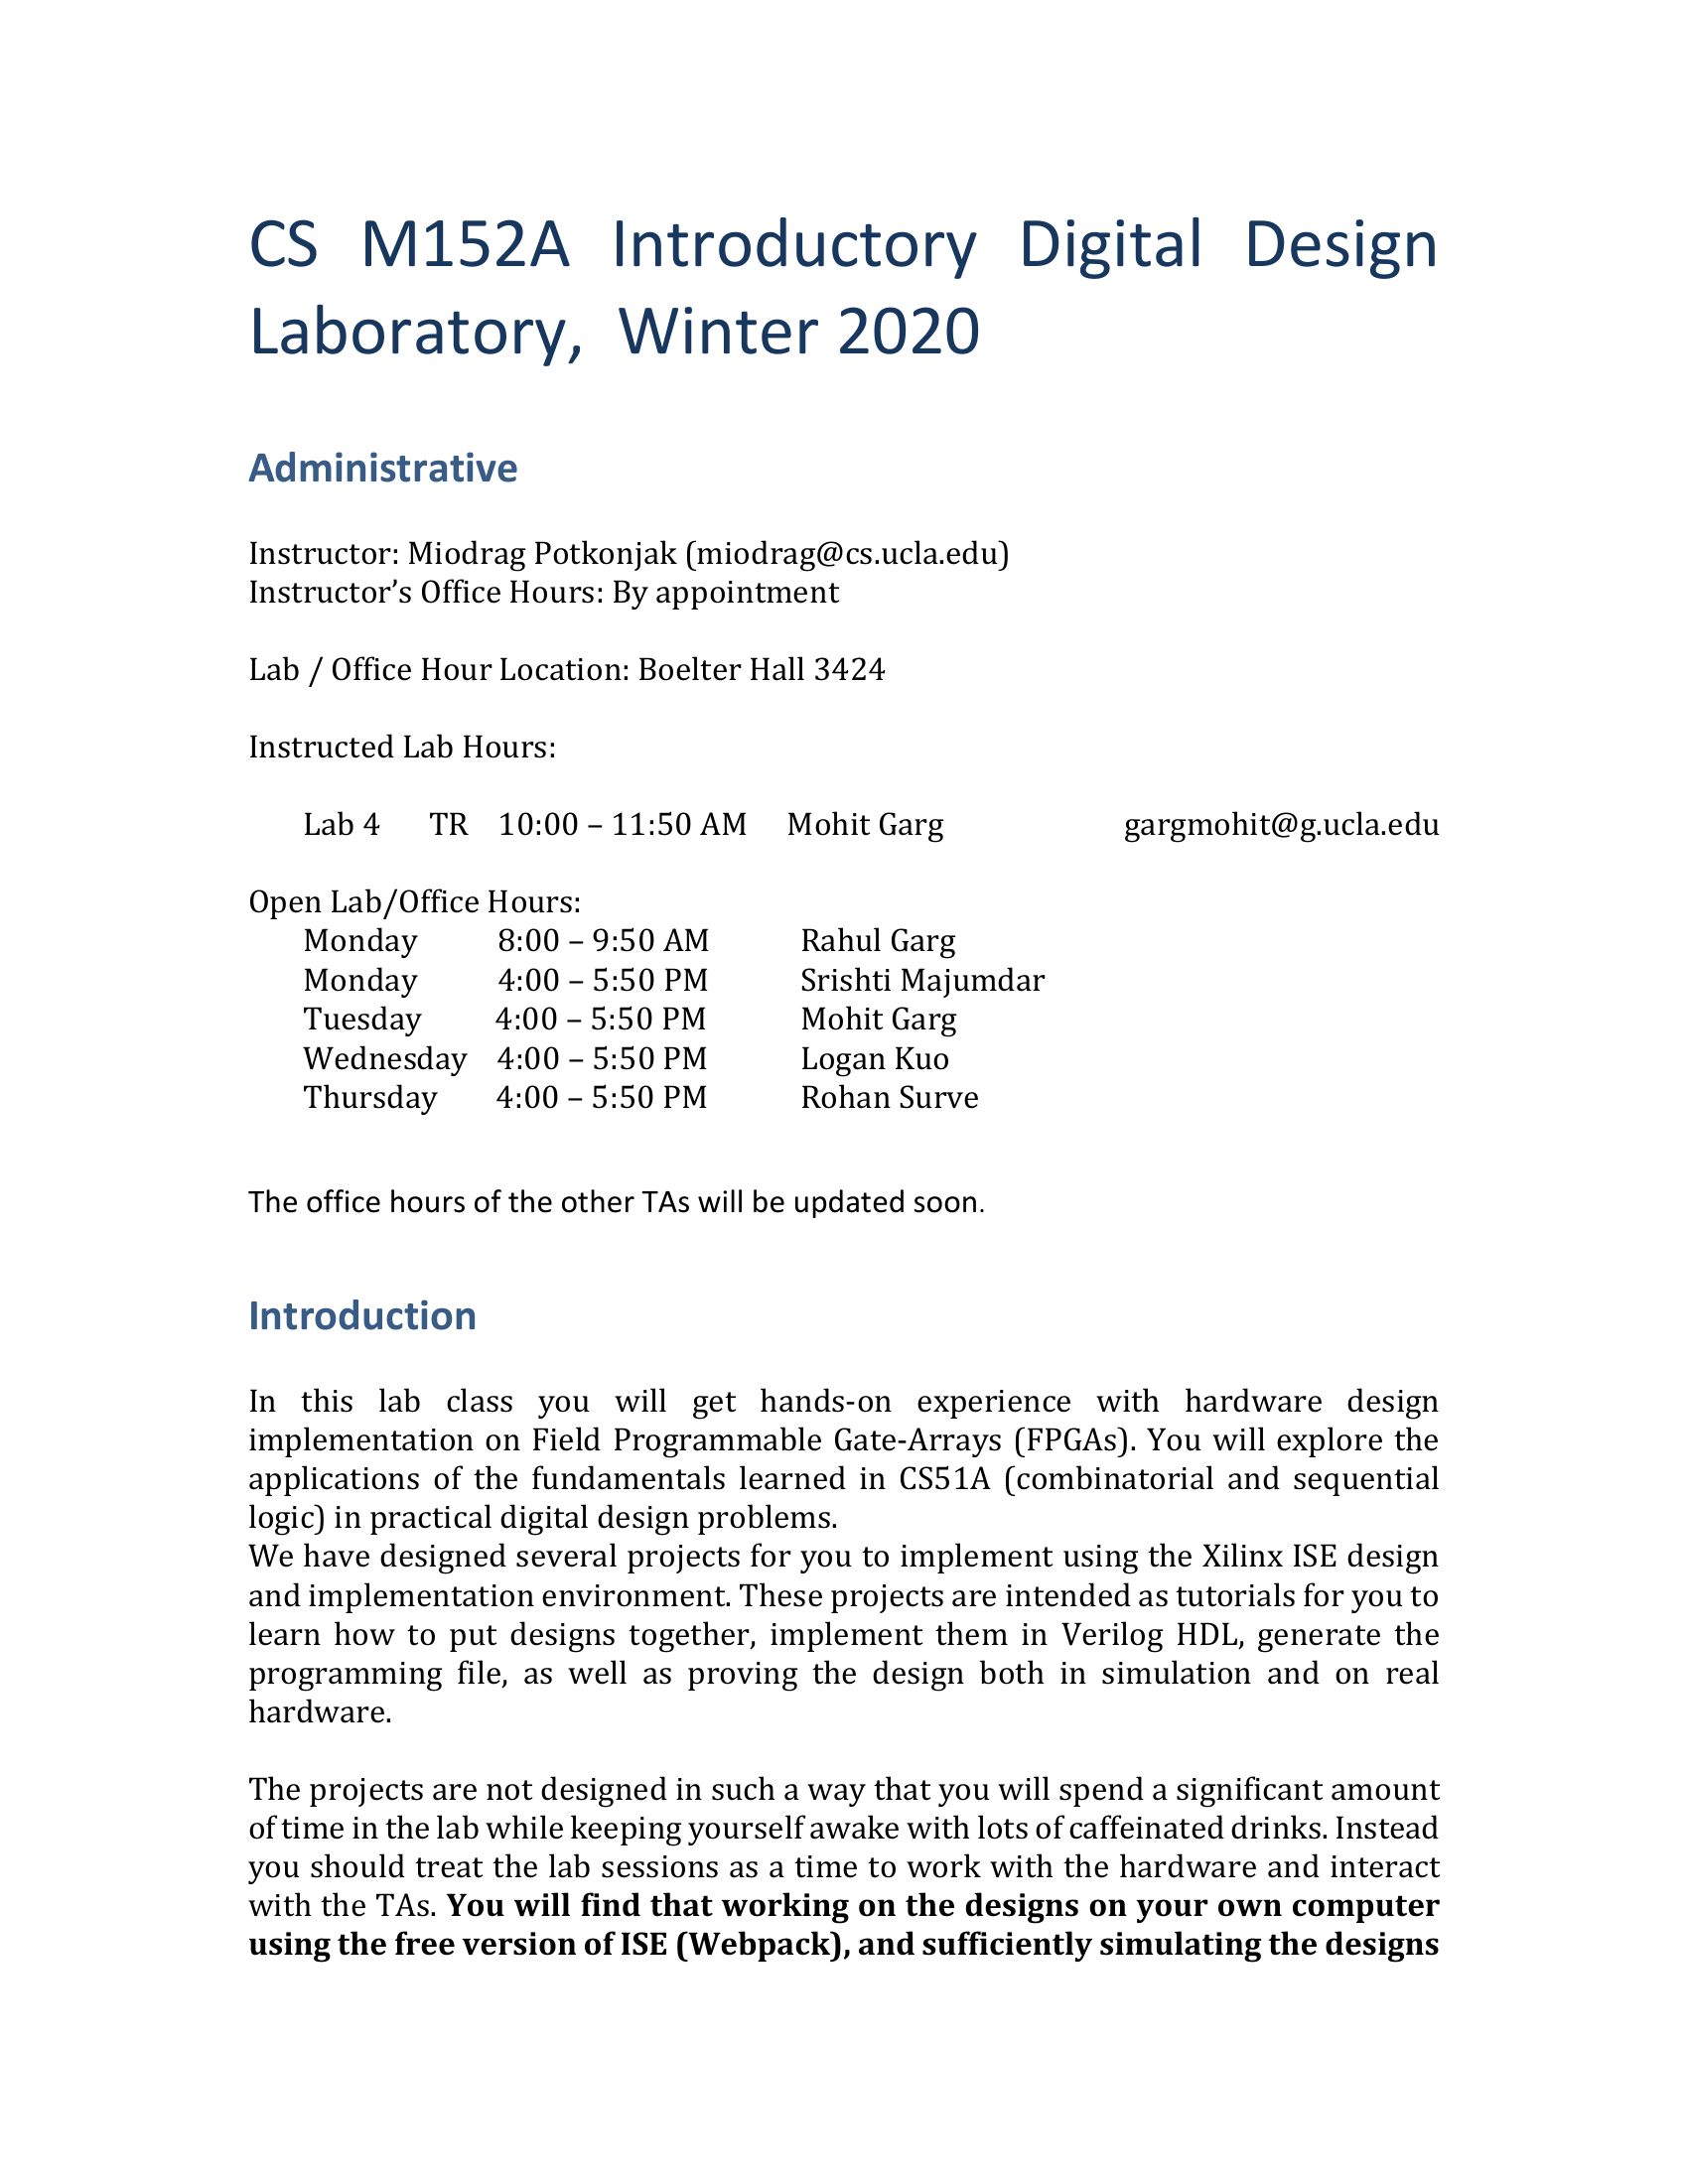

In [2]:
SYLLABUS = '../data/syllabi/csm152a_syllabus.pdf'
images = convert_from_path(SYLLABUS)
image = images[0]
image

In [3]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

/Users/rob/Developer/Python/knowledgeModels/.env/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 2560, 1920])


In [5]:
import torch

task_prompt = "<s_docvqa><s_question>{INPUT}</s_question><s_answer>"
question = "What day does Logan Kuo have open lab?"
prompt = task_prompt.replace("{INPUT}", question)
decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True)

In [6]:
seq = processor.batch_decode(outputs.sequences)[0]
seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token

In [7]:
processor.token2json(seq)

{'question': 'What day does Logan Kuo have open lab?', 'answer': 'wednesday'}